# San Francisco Crime Prediction 

## Notice !!!! Code Runs on : Anaconda (Python 3) Kernel

In [6]:
import numpy as np
import pandas as pd
import string
import re 
from patsy import dmatrices

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')

from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import log_loss #evaluation metric

from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

from datetime import datetime
from matplotlib.colors import LogNorm
from sklearn.metrics import accuracy_score,classification_report
from sklearn.decomposition import PCA

%matplotlib inline

### Reading Training Data Set

In [7]:
#reading the training data set
SNF = pd.read_csv("train.csv" , sep=',')
# names=['Dates','Category','Descript','DayOfWeek','PdDistrict','Resolution','Address','X','Y']

# printing size of data frame
print ('Size of data frame: ',SNF.shape)

Size of data frame:  (878049, 9)


In [4]:
# defining a function to find missing values
def count_missing(frame):
    return (frame.shape[0] * frame.shape[1]) - frame.count().sum()
# checking for missing values in data frame
print ('Missing Values: ', count_missing(SNF))

Missing Values:  0


### SAN FRANCISCO CRIME DATA MAP

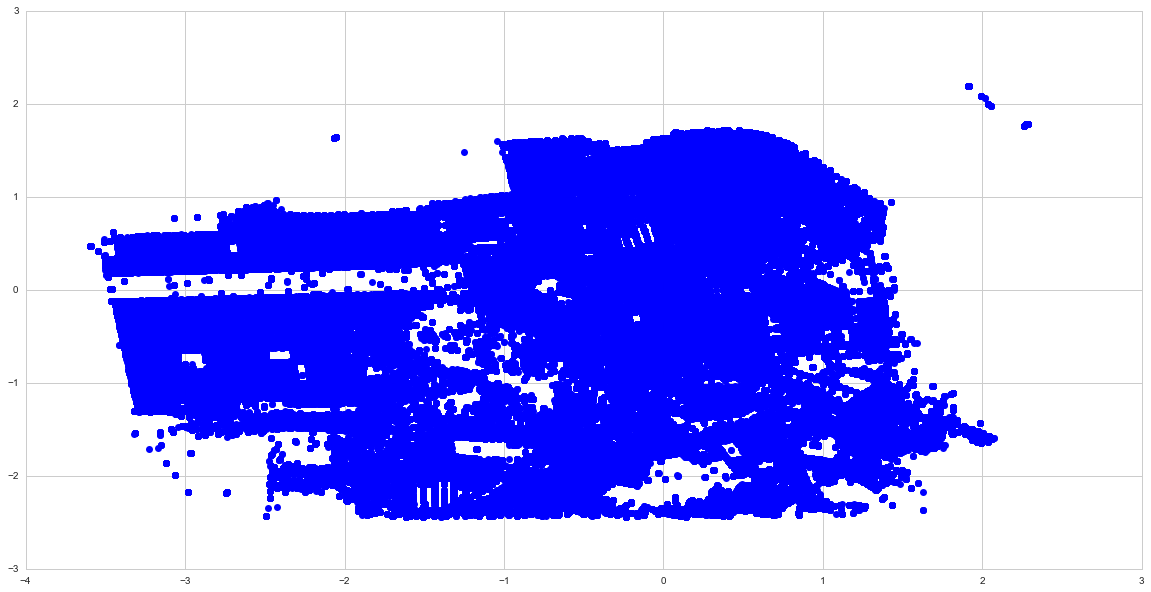

In [72]:
scaler = preprocessing.StandardScaler()
scaler.fit(SNF[["X","Y"]])
SNF[["X","Y"]] = scaler.transform(SNF[["X","Y"]])

SNF=SNF[abs(SNF["Y"])<100]
SNF.index=range(len(SNF))

plt.figure(figsize=(20,10))
plt.plot(SNF["X"],SNF["Y"],'bo')
plt.show()

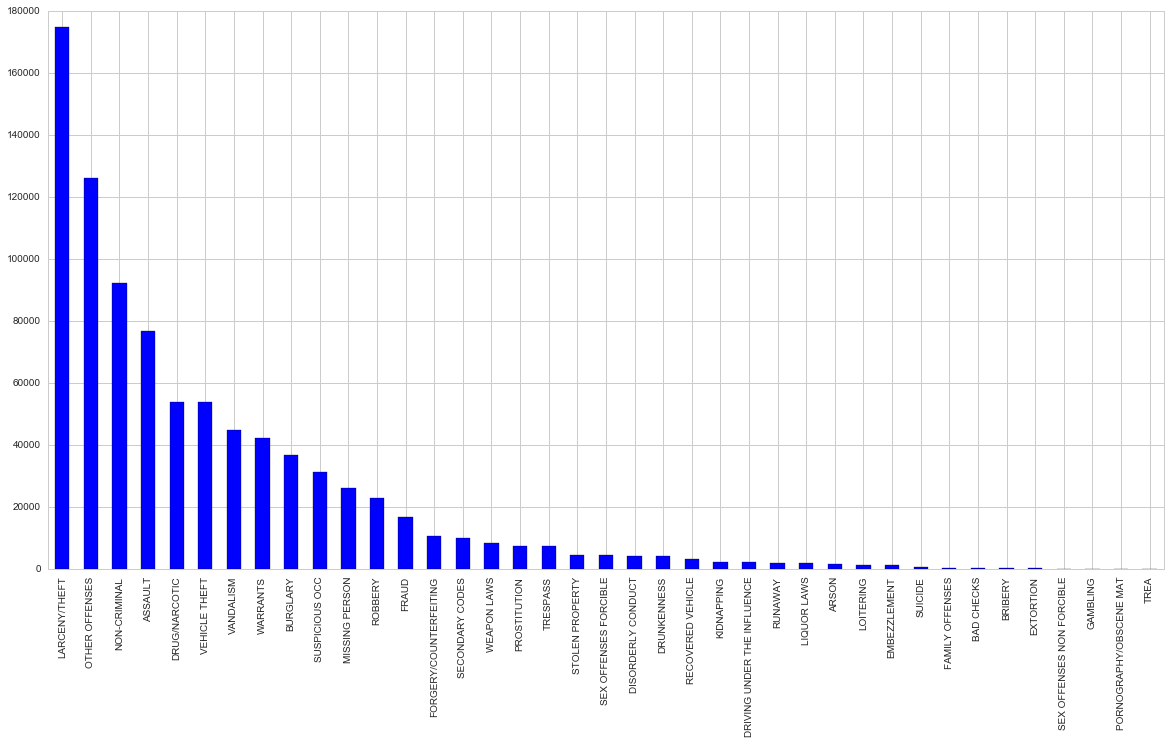

In [77]:
plt.figure(figsize=(20,10))
SNF.Category.value_counts().plot(kind='bar')

In [53]:
from IPython.display import IFrame
IFrame('map1.pdf',width=900,height=700)

In [52]:
from IPython.display import IFrame
IFrame('map3.pdf',width=900,height=700)

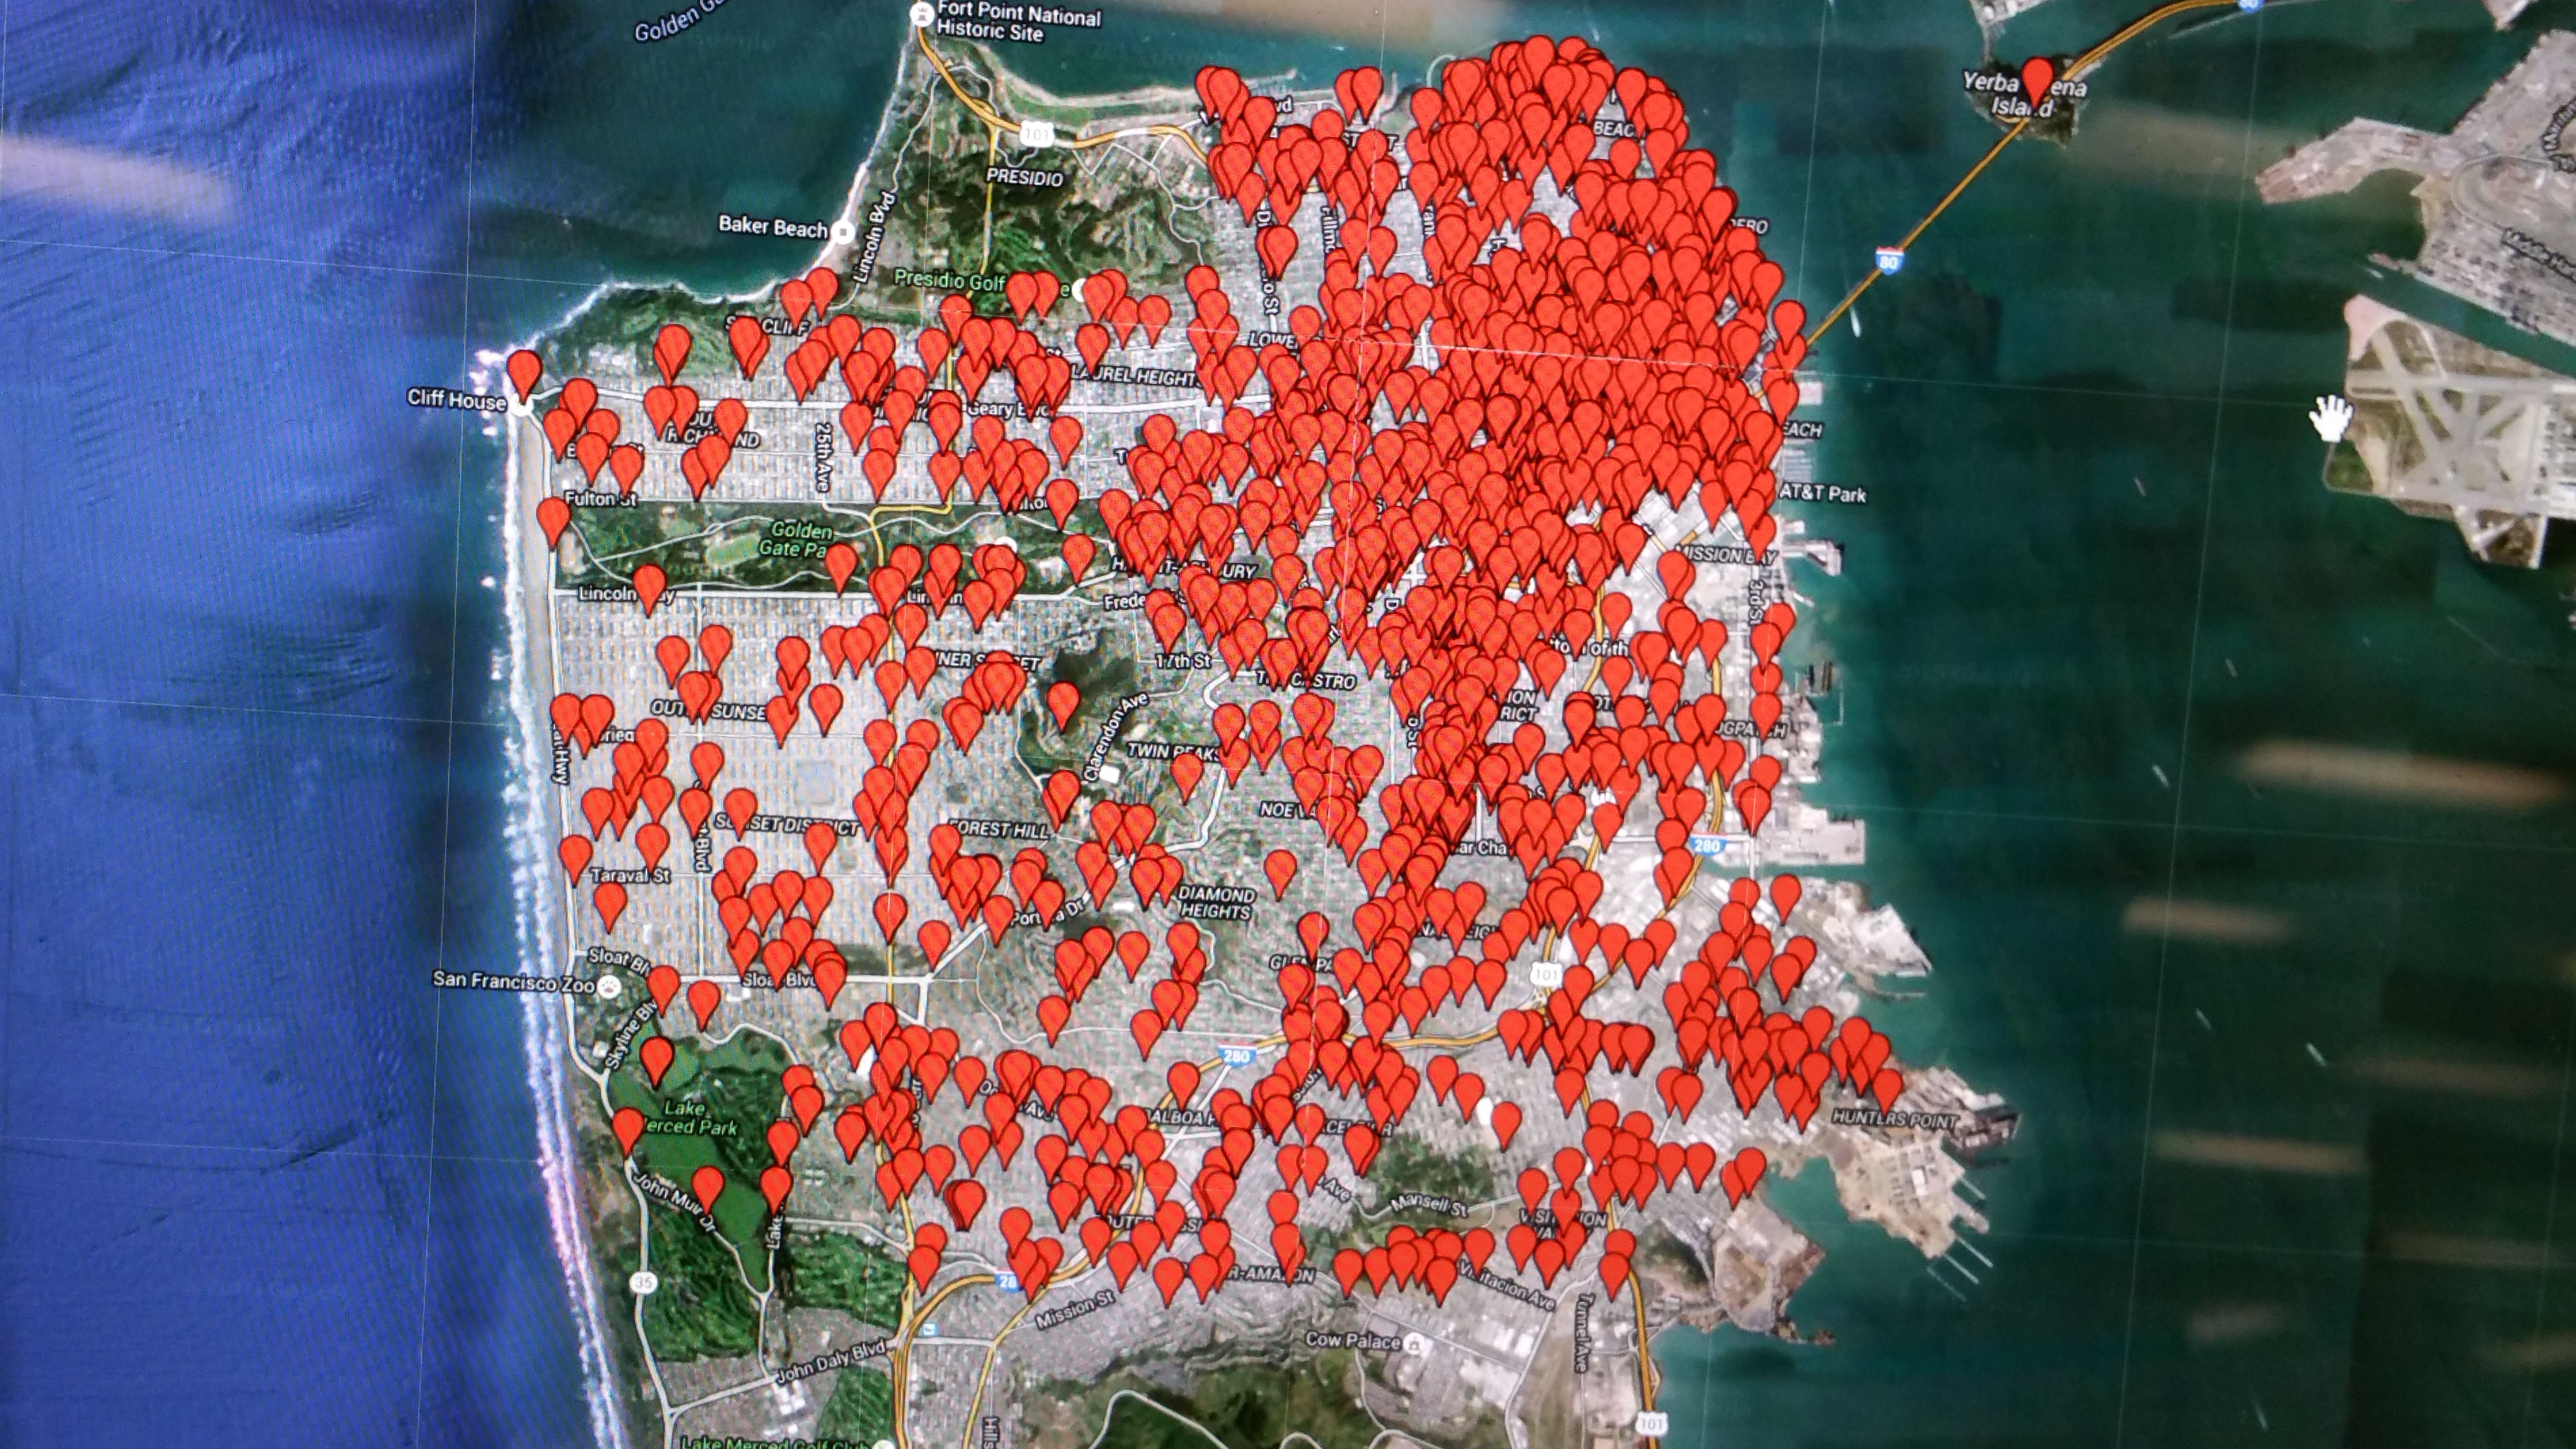

In [6]:
# Taking only the X,Y cordinates and plotting them on google
from IPython.core.display import Image
Image('map.jpg',width=900,height=100)

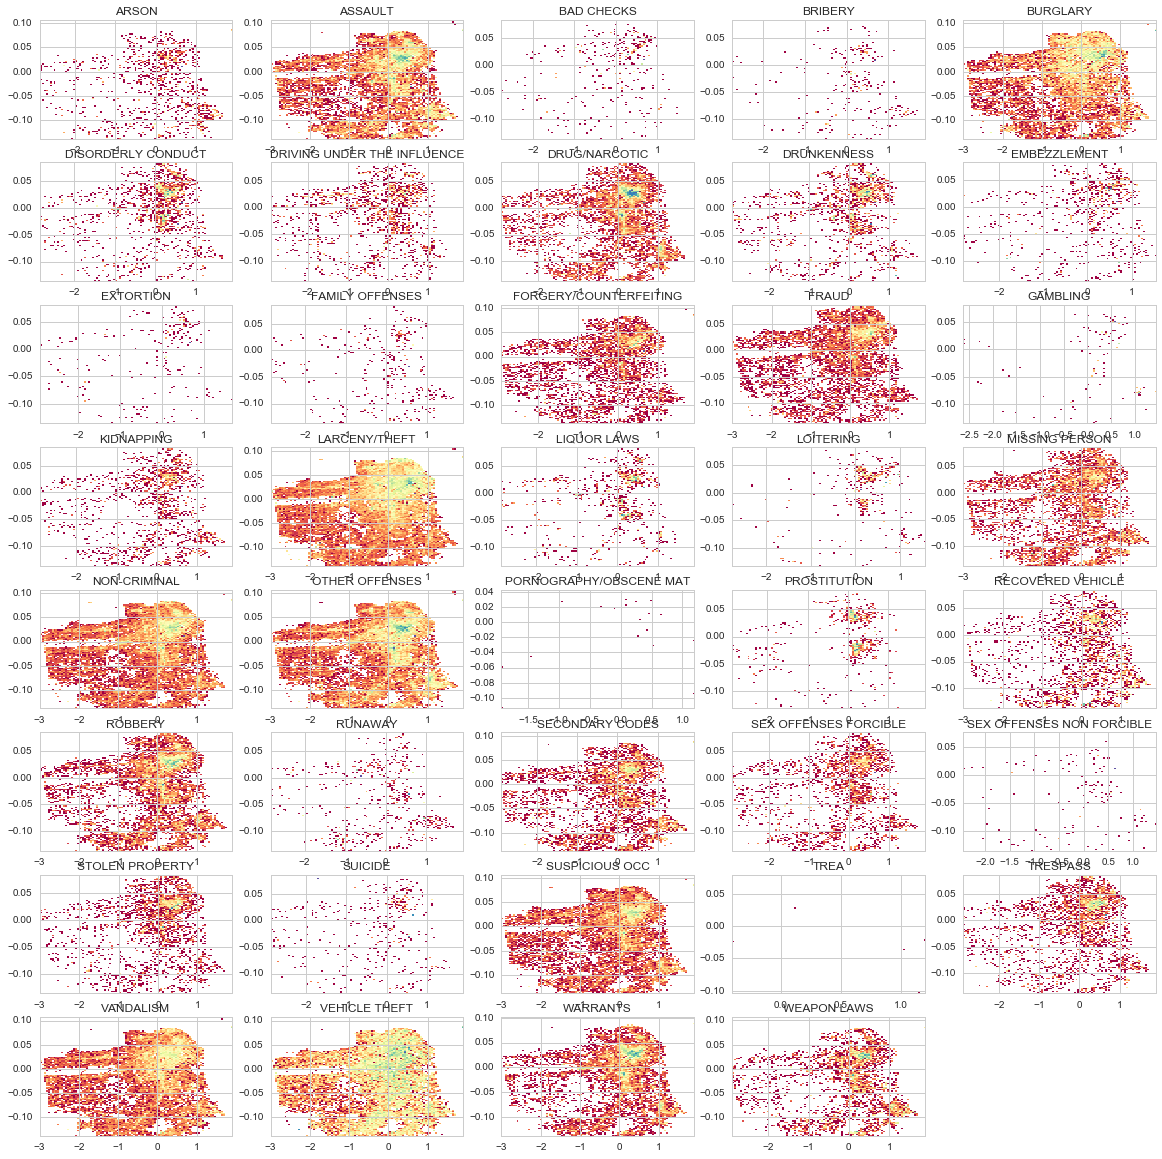

In [27]:
# 2D histogram of the response variable: Category
binX=100
binY=100
cat = SNF.groupby('Category')
i=1
plt.figure(figsize=(20, 20))
for name, group in cat:
    plt.subplot(8,5,i)
    histo, xedges, yedges = np.histogram2d(np.array(group.X),np.array(group.Y), bins=(binX,binY))
    
    plt.imshow(histo.T,origin='low',cmap=plt.cm.Spectral,extent=[xedges[0],xedges[-1],yedges[0],\
               yedges[-1]],interpolation='nearest',aspect='auto',norm=LogNorm())
    plt.title(name)
    i+=1
del cat

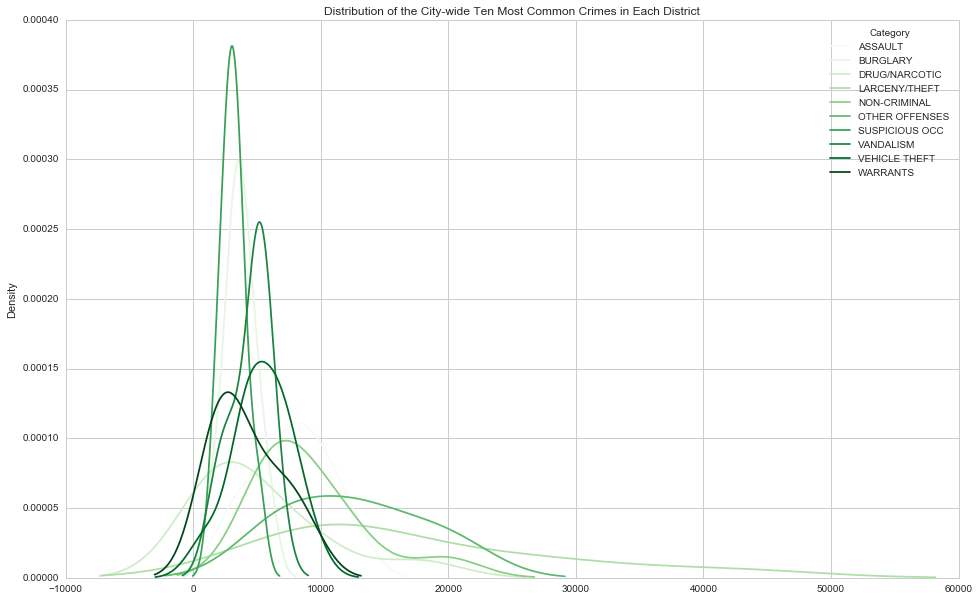

In [57]:
#Distribution of the City-wide Ten Most Common Crimes in Each District
ten_most_common = SNF[SNF['Category'].isin(SNF['Category'].value_counts().head(10).index)]

ten_most_crime_by_district = pd.crosstab(ten_most_common['PdDistrict'], ten_most_common['Category'])
ten_most_crime_by_district.plot(kind='kde', figsize=(16,10), stacked=True, colormap='Greens',
                                title='Distribution of the City-wide Ten Most Common Crimes in Each District')
plt.show()

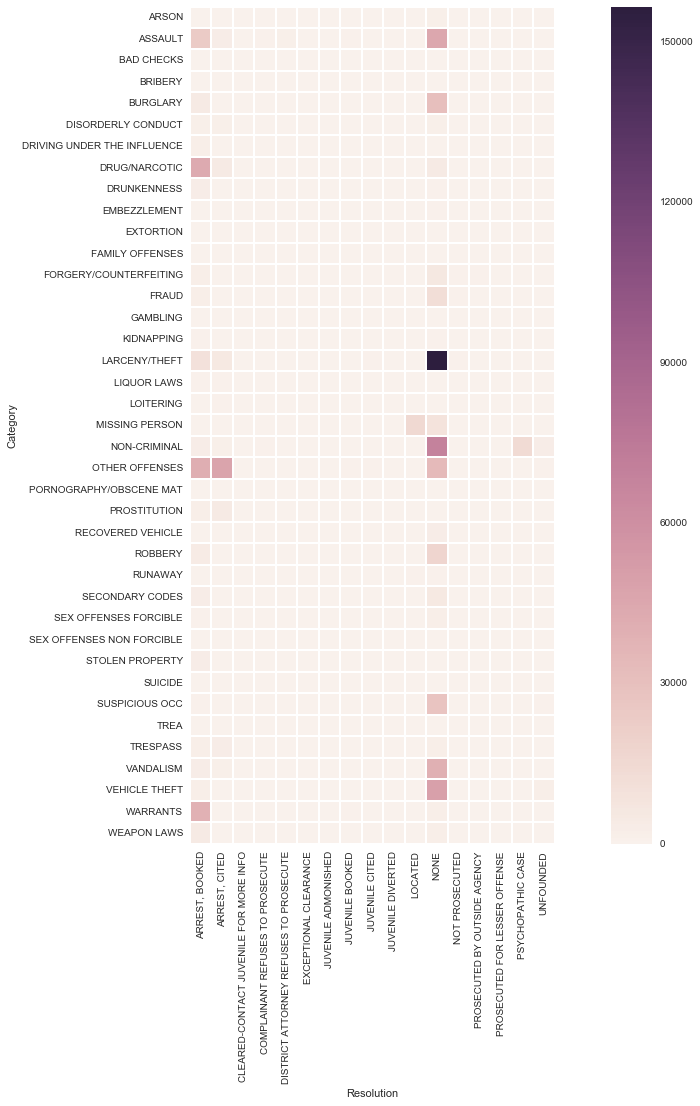

In [5]:
#heat map
plt.figure(figsize=(20,15))

rows = len(SNF.axes[0])
SNF = pd.crosstab(SNF['Category'], SNF['Resolution'])

sns.heatmap(SNF, square=True, linewidths=1, label='tiny')
plt.show()

In [68]:
def unique_counts():
    Ncat=len(pd.unique(SNF.Category.ravel()))
    print ("all "+str(Ncat)+" categories:")
    print (pd.unique(SNF.Category.ravel()))
    print('-'*100)

    Ndist=len(pd.unique(SNF.PdDistrict.ravel()))
    print ("all "+str(Ndist)+" districts:")
    print (pd.unique(SNF.PdDistrict.ravel()))

    print('-'*100)
    Nd=len(pd.unique(SNF.DayOfWeek.ravel()))
    print ("all "+str(Nd)+" dayofweek:")
    print (pd.unique(SNF.DayOfWeek.ravel()))

    print('-'*100)
    Nds=len(pd.unique(SNF.PdDistrict.ravel()))
    print ("all "+str(Nds)+" PdDistrict:")
    print (pd.unique(SNF.PdDistrict.ravel()))
    print('-'*100)

    Ndis=len(pd.unique(SNF.Resolution.ravel()))
    print ("all "+str(Ndis)+" Resolution:")
    print (pd.unique(SNF.Resolution.ravel()))

unique_counts()

all 39 categories:
['WARRANTS' 'OTHER OFFENSES' 'LARCENY/THEFT' 'VEHICLE THEFT' 'VANDALISM'
 'NON-CRIMINAL' 'ROBBERY' 'ASSAULT' 'WEAPON LAWS' 'BURGLARY'
 'SUSPICIOUS OCC' 'DRUNKENNESS' 'FORGERY/COUNTERFEITING' 'DRUG/NARCOTIC'
 'STOLEN PROPERTY' 'SECONDARY CODES' 'TRESPASS' 'MISSING PERSON' 'FRAUD'
 'KIDNAPPING' 'RUNAWAY' 'DRIVING UNDER THE INFLUENCE'
 'SEX OFFENSES FORCIBLE' 'PROSTITUTION' 'DISORDERLY CONDUCT' 'ARSON'
 'FAMILY OFFENSES' 'LIQUOR LAWS' 'BRIBERY' 'EMBEZZLEMENT' 'SUICIDE'
 'LOITERING' 'SEX OFFENSES NON FORCIBLE' 'EXTORTION' 'GAMBLING'
 'BAD CHECKS' 'TREA' 'RECOVERED VEHICLE' 'PORNOGRAPHY/OBSCENE MAT']
----------------------------------------------------------------------------------------------------
all 10 districts:
['NORTHERN' 'PARK' 'INGLESIDE' 'BAYVIEW' 'RICHMOND' 'CENTRAL' 'TARAVAL'
 'TENDERLOIN' 'MISSION' 'SOUTHERN']
----------------------------------------------------------------------------------------------------
all 7 dayofweek:
['Wednesday' 'Tuesday' 'Monday' '

In [30]:
#getting the column names
SNF.columns.values

array(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y'], dtype=object)

In [63]:
#getting head of data set
SNF.head()

Dates        Category                      Descript  \
0  2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1  2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2  2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address         X  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST -0.107902   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST -0.107902   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST -0.057541   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST -0.144262   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST -0.531112   

          Y  
0  0.007832  
1  0.007832  
2  0.064335  
3  0.065338  
4  0.001140

In [33]:
#getting tail of data set
SNF.tail()

Dates                Category  \
877977  2003-01-06 00:15:00                 ROBBERY   
877978  2003-01-06 00:01:00           LARCENY/THEFT   
877979  2003-01-06 00:01:00           LARCENY/THEFT   
877980  2003-01-06 00:01:00               VANDALISM   
877981  2003-01-06 00:01:00  FORGERY/COUNTERFEITING   

                                         Descript DayOfWeek PdDistrict  \
877977           ROBBERY ON THE STREET WITH A GUN    Monday    TARAVAL   
877978               GRAND THEFT FROM LOCKED AUTO    Monday  INGLESIDE   
877979               GRAND THEFT FROM LOCKED AUTO    Monday   SOUTHERN   
877980  MALICIOUS MISCHIEF, VANDALISM OF VEHICLES    Monday   SOUTHERN   
877981                   CHECKS, FORGERY (FELONY)    Monday    BAYVIEW   

       Resolution                     Address         X         Y  
877977       NONE  FARALLONES ST / CAPITOL AV -1.199747 -0.124677  
877978       NONE        600 Block of EDNA ST -0.815292 -0.085518  
877979       NONE          5TH ST / FOLSOM ST  0.633404  0.020235  
877980       NONE        TOWNSEND ST / 2ND ST  1.057042  0.020983  
877981       NONE    1800 Block of NEWCOMB AV  0.912272 -0.071808

In [34]:
#checking data frame info
SNF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 877982 entries, 0 to 877981
Data columns (total 9 columns):
Dates         877982 non-null object
Category      877982 non-null object
Descript      877982 non-null object
DayOfWeek     877982 non-null object
PdDistrict    877982 non-null object
Resolution    877982 non-null object
Address       877982 non-null object
X             877982 non-null float64
Y             877982 non-null float64
dtypes: float64(2), object(7)
memory usage: 67.0+ MB


In [35]:
#length of each words in the category column
def word_length(SNF):
    SNF['CategoryLength'] = SNF['Category'].apply(len)
    return SNF.head()

In [36]:
word_length(SNF)

Dates        Category                      Descript  \
0  2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1  2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2  2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address         X  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST -0.107902   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST -0.107902   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST -0.057541   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST -0.144262   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST -0.531112   

          Y  CategoryLength  
0  0.007832               8  
1  0.007832              14  
2  0.064335              14  
3  0.065338              13  
4  0.001140              13

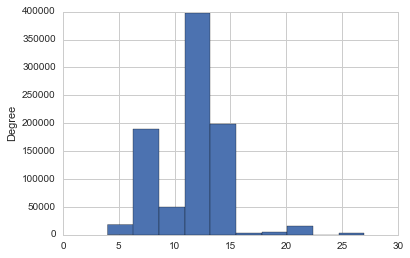

In [37]:
SNF['CategoryLength'].plot(bins=10,kind="hist")

In [38]:
#category length statistics
SNF['CategoryLength'].describe()

count    877982.000000
mean         11.741599
std           3.123013
min           4.000000
25%           9.000000
50%          13.000000
75%          14.000000
max          27.000000
Name: CategoryLength, dtype: float64

In [39]:
#category of length 27 : max
SNF[SNF['CategoryLength']==27]

Dates                     Category  \
351     2015-05-13 00:56:00  DRIVING UNDER THE INFLUENCE   
1437    2015-05-03 02:17:00  DRIVING UNDER THE INFLUENCE   
1507    2015-05-02 23:10:00  DRIVING UNDER THE INFLUENCE   
1610    2015-05-02 19:00:00  DRIVING UNDER THE INFLUENCE   
1658    2015-05-02 16:56:00  DRIVING UNDER THE INFLUENCE   
1845    2015-05-02 00:54:00  DRIVING UNDER THE INFLUENCE   
1856    2015-05-02 00:12:00  DRIVING UNDER THE INFLUENCE   
2663    2015-04-30 00:15:00  DRIVING UNDER THE INFLUENCE   
3694    2015-04-27 13:54:00  DRIVING UNDER THE INFLUENCE   
5176    2015-04-17 00:35:00  DRIVING UNDER THE INFLUENCE   
5575    2015-04-16 00:19:00  DRIVING UNDER THE INFLUENCE   
5977    2015-04-15 02:48:00  DRIVING UNDER THE INFLUENCE   
6066    2015-04-14 22:04:00  DRIVING UNDER THE INFLUENCE   
6086    2015-04-14 21:22:00  DRIVING UNDER THE INFLUENCE   
6398    2015-04-13 23:54:00  DRIVING UNDER THE INFLUENCE   
6880    2015-04-05 19:31:00  DRIVING UNDER THE INFLUENCE   
7093    2015-04-05 06:53:00  DRIVING UNDER THE INFLUENCE   
7573    2015-04-04 00:40:00  DRIVING UNDER THE INFLUENCE   
8217    2015-04-02 17:44:00  DRIVING UNDER THE INFLUENCE   
8469    2015-04-01 23:20:00  DRIVING UNDER THE INFLUENCE   
8879    2015-03-31 22:18:00  DRIVING UNDER THE INFLUENCE   
9721    2015-03-22 20:35:00  DRIVING UNDER THE INFLUENCE   
9984    2015-03-22 06:32:00  DRIVING UNDER THE INFLUENCE   
10415   2015-03-21 07:46:00  DRIVING UNDER THE INFLUENCE   
10500   2015-03-20 23:45:00  DRIVING UNDER THE INFLUENCE   
10504   2015-03-20 23:35:00  DRIVING UNDER THE INFLUENCE   
10528   2015-03-20 22:46:00  DRIVING UNDER THE INFLUENCE   
10539   2015-03-20 22:27:00  DRIVING UNDER THE INFLUENCE   
11675   2015-03-18 09:29:00  DRIVING UNDER THE INFLUENCE   
11939   2015-03-17 17:54:00  DRIVING UNDER THE INFLUENCE   
...                     ...                          ...   
860496  2003-03-23 22:21:00  DRIVING UNDER THE INFLUENCE   
861161  2003-03-22 00:13:00  DRIVING UNDER THE INFLUENCE   
861594  2003-03-20 23:10:00  DRIVING UNDER THE INFLUENCE   
862473  2003-03-18 19:43:00  DRIVING UNDER THE INFLUENCE   
863261  2003-03-09 21:55:00  DRIVING UNDER THE INFLUENCE   
864481  2003-03-07 00:19:00  DRIVING UNDER THE INFLUENCE   
864524  2003-03-06 22:29:00  DRIVING UNDER THE INFLUENCE   
864635  2003-03-06 18:06:00  DRIVING UNDER THE INFLUENCE   
865894  2003-03-03 19:20:00  DRIVING UNDER THE INFLUENCE   
866177  2003-03-03 00:40:00  DRIVING UNDER THE INFLUENCE   
866753  2003-02-22 15:05:00  DRIVING UNDER THE INFLUENCE   
866986  2003-02-21 23:56:00  DRIVING UNDER THE INFLUENCE   
867068  2003-02-21 19:57:00  DRIVING UNDER THE INFLUENCE   
869837  2003-02-08 02:01:00  DRIVING UNDER THE INFLUENCE   
869855  2003-02-08 01:25:00  DRIVING UNDER THE INFLUENCE   
871333  2003-02-04 21:15:00  DRIVING UNDER THE INFLUENCE   
872477  2003-01-26 01:15:00  DRIVING UNDER THE INFLUENCE   
872942  2003-01-25 00:27:00  DRIVING UNDER THE INFLUENCE   
873026  2003-01-24 21:32:00  DRIVING UNDER THE INFLUENCE   
873831  2003-01-23 02:57:00  DRIVING UNDER THE INFLUENCE   
873838  2003-01-23 02:31:00  DRIVING UNDER THE INFLUENCE   
875098  2003-01-20 02:15:00  DRIVING UNDER THE INFLUENCE   
875398  2003-01-12 04:00:00  DRIVING UNDER THE INFLUENCE   
875529  2003-01-11 20:30:00  DRIVING UNDER THE INFLUENCE   
875774  2003-01-11 02:46:00  DRIVING UNDER THE INFLUENCE   
875799  2003-01-11 00:31:00  DRIVING UNDER THE INFLUENCE   
876195  2003-01-10 02:23:00  DRIVING UNDER THE INFLUENCE   
876196  2003-01-10 02:09:00  DRIVING UNDER THE INFLUENCE   
876603  2003-01-09 02:11:00  DRIVING UNDER THE INFLUENCE   
877124  2003-01-08 02:29:00  DRIVING UNDER THE INFLUENCE   

                                                 Descript  DayOfWeek  \
351          DRIVING WHILE UNDER THE INFLUENCE OF ALCOHOL  Wednesday   
1437         DRIVING WHILE UNDER THE INFLUENCE OF ALCOHOL     Sunday   
1507         DRIVING WHILE UNDER THE INFLUENCE OF ALCOHOL   Saturday   
1610         

In [40]:
#count number Driving under the influence
len(SNF[SNF['CategoryLength']==27])

2268

In [41]:
# category of length 4 : min
SNF[SNF['CategoryLength']==4]

Dates Category  \
21002   2015-02-03 17:05:00     TREA   
93716   2014-02-17 06:38:00     TREA   
107733  2013-11-30 05:59:00     TREA   
192190  2012-10-20 22:27:00     TREA   
316490  2010-12-31 16:20:00     TREA   
337880  2010-09-09 11:55:00     TREA   

                                                 Descript DayOfWeek  \
21002   TRESPASSING OR LOITERING NEAR POSTED INDUSTRIA...   Tuesday   
93716   TRESPASSING OR LOITERING NEAR POSTED INDUSTRIA...    Monday   
107733  TRESPASSING OR LOITERING NEAR POSTED INDUSTRIA...  Saturday   
192190  TRESPASSING OR LOITERING NEAR POSTED INDUSTRIA...  Saturday   
316490  TRESPASSING OR LOITERING NEAR POSTED INDUSTRIA...    Friday   
337880  TRESPASSING OR LOITERING NEAR POSTED INDUSTRIA...  Thursday   

       PdDistrict      Resolution                     Address         X  \
21002     BAYVIEW            NONE        300 Block of 20TH ST  1.202872   
93716     MISSION  ARREST, BOOKED      500 Block of CASTRO ST -0.407804   
107733   NORTHERN  ARREST, BOOKED        700 Block of POLK ST  0.110894   
192190    BAYVIEW            NONE  1300 Block of ARMSTRONG AV  1.152957   
316490    CENTRAL  ARREST, BOOKED   2300 Block of STOCKTON ST  0.393857   
337880    BAYVIEW            NONE       1000 Block of IOWA ST  1.018273   

               Y  CategoryLength  
21002  -0.022604               4  
93716  -0.023968               4  
107733  0.027986               4  
192190 -0.103930               4  
316490  0.079685               4  
337880 -0.037533               4

In [42]:
#count number of Trespassing or Loitering near posted industrial
len(SNF[SNF['CategoryLength']==4])

6

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114c94be0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x109b1c320>]], dtype=object)

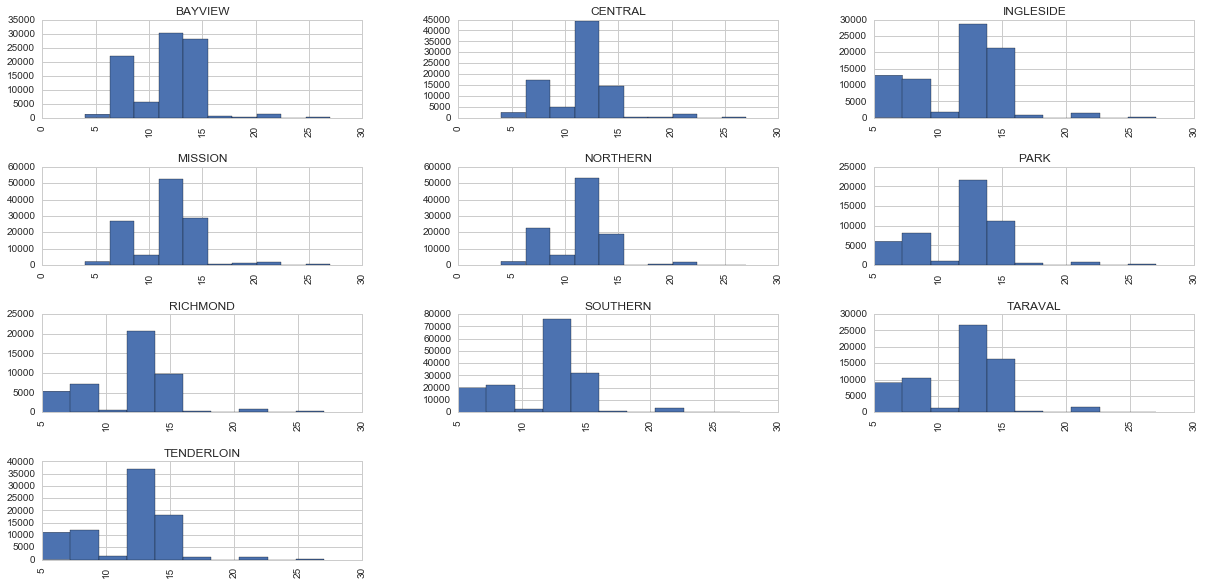

In [43]:
SNF.hist(column='CategoryLength',by=SNF['PdDistrict'],bins=10,figsize=(20,10))

In [46]:
#group by address and category
A_C_counts=SNF.groupby(["Address"]).size()
A_C_counts

Address
0 Block of  HARRISON ST        1
0 Block of 10TH AV             5
0 Block of 10TH ST            49
0 Block of 11TH ST            48
0 Block of 12TH AV             7
0 Block of 12TH ST           436
0 Block of 13TH ST            46
0 Block of 14TH AV             6
0 Block of 14TH ST            59
0 Block of 15TH AV             6
0 Block of 15TH ST             7
0 Block of 16TH AV             5
0 Block of 17TH AV             6
0 Block of 18TH AV            17
0 Block of 19TH AV             7
0 Block of 1ST ST            153
0 Block of 20TH AV             7
0 Block of 21ST AV            20
0 Block of 22ND AV             9
0 Block of 25TH AV            18
0 Block of 26TH AV             7
0 Block of 27TH AV             3
0 Block of 27TH ST             8
0 Block of 28TH ST            48
0 Block of 29TH ST            55
0 Block of 2ND AV              2
0 Block of 2ND ST            147
0 Block of 30TH ST            65
0 Block of 36TH AV             4
0 Block of 3RD AV              4
  

In [ ]:
#plt.figure(figsize=(20,10))
#sns.boxplot(x=SNF["year"], y=SNF["month"],data=SNF, palette="Set3",whis=1.5)

In [47]:
# getting unique counts : DayOfWeek column
day = SNF['DayOfWeek'].unique()
day_dict = {value:index for index,value in enumerate(day)}
dy = SNF['DayOfWeek'].map(day_dict)
day_dict

{'Friday': 5,
 'Monday': 2,
 'Saturday': 4,
 'Sunday': 3,
 'Thursday': 6,
 'Tuesday': 1,
 'Wednesday': 0}

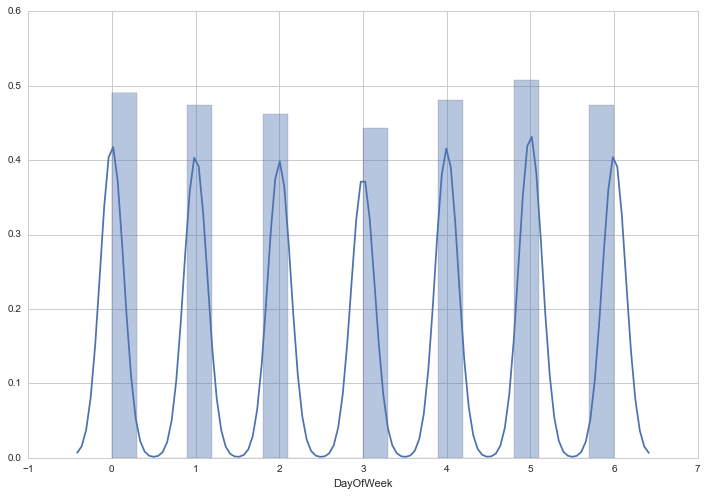

In [48]:
#draw histogram of the distribution of PdDistrict
plt.figure(figsize=(12,8))
sns.distplot(dy,bins=20,kde=True)

In [49]:
# getting unique counts : Category column
district = SNF['PdDistrict'].unique()
district_dict = {value:index for index,value in enumerate(district)}
d = SNF['PdDistrict'].map(district_dict)
district_dict

{'BAYVIEW': 3,
 'CENTRAL': 5,
 'INGLESIDE': 2,
 'MISSION': 8,
 'NORTHERN': 0,
 'PARK': 1,
 'RICHMOND': 4,
 'SOUTHERN': 9,
 'TARAVAL': 6,
 'TENDERLOIN': 7}

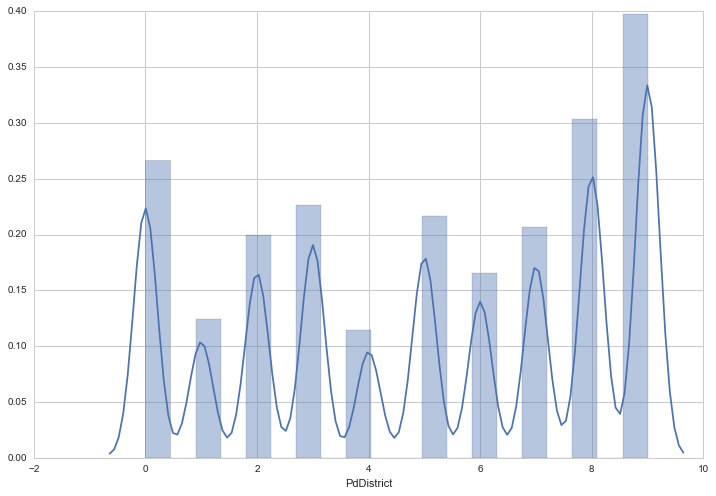

In [50]:
#draw histogram of the distribution of PdDistrict
plt.figure(figsize=(12,8))
sns.distplot(d,bins=20,kde=True)

In [51]:
# getting unique counts : Category column
categories = SNF['Category'].unique()
category_dict = {value:index for index,value in enumerate(categories)}
y = SNF['Category'].map(category_dict)
category_dict

{'ARSON': 25,
 'ASSAULT': 7,
 'BAD CHECKS': 35,
 'BRIBERY': 28,
 'BURGLARY': 9,
 'DISORDERLY CONDUCT': 24,
 'DRIVING UNDER THE INFLUENCE': 21,
 'DRUG/NARCOTIC': 13,
 'DRUNKENNESS': 11,
 'EMBEZZLEMENT': 29,
 'EXTORTION': 33,
 'FAMILY OFFENSES': 26,
 'FORGERY/COUNTERFEITING': 12,
 'FRAUD': 18,
 'GAMBLING': 34,
 'KIDNAPPING': 19,
 'LARCENY/THEFT': 2,
 'LIQUOR LAWS': 27,
 'LOITERING': 31,
 'MISSING PERSON': 17,
 'NON-CRIMINAL': 5,
 'OTHER OFFENSES': 1,
 'PORNOGRAPHY/OBSCENE MAT': 38,
 'PROSTITUTION': 23,
 'RECOVERED VEHICLE': 37,
 'ROBBERY': 6,
 'RUNAWAY': 20,
 'SECONDARY CODES': 15,
 'SEX OFFENSES FORCIBLE': 22,
 'SEX OFFENSES NON FORCIBLE': 32,
 'STOLEN PROPERTY': 14,
 'SUICIDE': 30,
 'SUSPICIOUS OCC': 10,
 'TREA': 36,
 'TRESPASS': 16,
 'VANDALISM': 4,
 'VEHICLE THEFT': 3,
 'WARRANTS': 0,
 'WEAPON LAWS': 8}

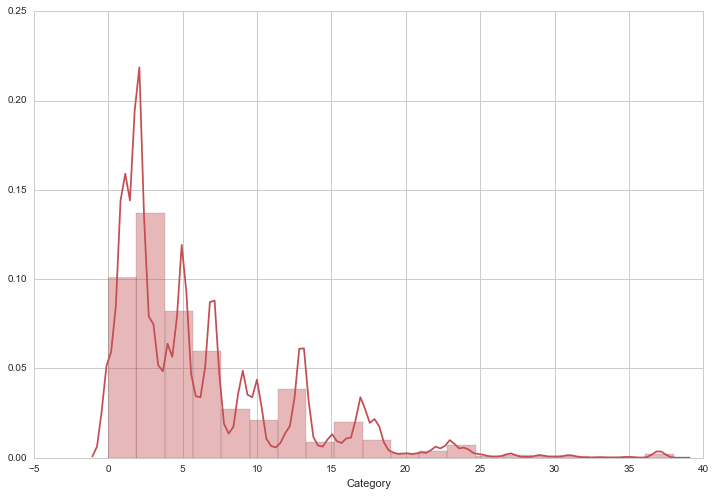

In [52]:
#draw histogram of the distribution of the response variable: y
plt.figure(figsize=(12,8))
sns.set_color_codes()
sns.distplot(y,bins=20,kde=True,color='r')

## MODEL BUILDING

In [55]:
# Read test data
def loading_test_data():
    test = pd.read_csv("test.csv")
    return test

In [56]:
loading_test_data().head()

Id                Dates DayOfWeek PdDistrict                   Address  \
0   0  2015-05-10 23:59:00    Sunday    BAYVIEW   2000 Block of THOMAS AV   
1   1  2015-05-10 23:51:00    Sunday    BAYVIEW        3RD ST / REVERE AV   
2   2  2015-05-10 23:50:00    Sunday   NORTHERN    2000 Block of GOUGH ST   
3   3  2015-05-10 23:45:00    Sunday  INGLESIDE  4700 Block of MISSION ST   
4   4  2015-05-10 23:45:00    Sunday  INGLESIDE  4700 Block of MISSION ST   

            X          Y  
0 -122.399588  37.735051  
1 -122.391523  37.732432  
2 -122.426002  37.792212  
3 -122.437394  37.721412  
4 -122.437394  37.721412

In [13]:
# Recode the Response variable 
category = preprocessing.LabelEncoder()
category_crime = category.fit_transform(SNF.Category)
print(category_crime)

[37 21 21 ..., 16 35 12]


In [11]:
category.inverse_transform(category_crime)

array(['WARRANTS', 'OTHER OFFENSES', 'OTHER OFFENSES', ...,
       'LARCENY/THEFT', 'VANDALISM', 'FORGERY/COUNTERFEITING'], dtype=object)

In [12]:
category.classes_

array(['ARSON', 'ASSAULT', 'BAD CHECKS', 'BRIBERY', 'BURGLARY',
       'DISORDERLY CONDUCT', 'DRIVING UNDER THE INFLUENCE',
       'DRUG/NARCOTIC', 'DRUNKENNESS', 'EMBEZZLEMENT', 'EXTORTION',
       'FAMILY OFFENSES', 'FORGERY/COUNTERFEITING', 'FRAUD', 'GAMBLING',
       'KIDNAPPING', 'LARCENY/THEFT', 'LIQUOR LAWS', 'LOITERING',
       'MISSING PERSON', 'NON-CRIMINAL', 'OTHER OFFENSES',
       'PORNOGRAPHY/OBSCENE MAT', 'PROSTITUTION', 'RECOVERED VEHICLE',
       'ROBBERY', 'RUNAWAY', 'SECONDARY CODES', 'SEX OFFENSES FORCIBLE',
       'SEX OFFENSES NON FORCIBLE', 'STOLEN PROPERTY', 'SUICIDE',
       'SUSPICIOUS OCC', 'TREA', 'TRESPASS', 'VANDALISM', 'VEHICLE THEFT',
       'WARRANTS', 'WEAPON LAWS'], dtype=object)

In [8]:
#feature normalization
def normalize(data): 
    data = (data - data.min()) / (data.max() - data.min())
    return data

SNF['X'] = normalize(SNF.X)
SNF['Y'] = normalize(SNF.Y)

In [9]:
def parse_time(x):
    DD=datetime.strptime(x,"%Y-%m-%d %H:%M:%S")
    time=DD.hour
    day=DD.day
    month=DD.month
    year=DD.year
    return time, day, month, year

#getting season : summer, fall, winter, spring from months column
def get_season(x):
    summer=0
    fall=0
    winter=0
    spring=0
    if (x in [5, 6, 7]):
        summer=1
    if (x in [8, 9, 10]):
        fall=1
    if (x in [11, 0, 1]):
        winter=1
    if (x in [2, 3, 4]):
        spring=1
    return summer, fall, winter, spring


In [10]:
%%time
def preprocess_data(df):
    """
    Preprocessing Training/Testing Data 
    """
    feature_list=df.columns.tolist()
    if "Descript" in feature_list:
        feature_list.remove("Descript")
    if "Resolution" in feature_list:
        feature_list.remove("Resolution")
    if "Category" in feature_list:
        feature_list.remove("Category")
    if "Id" in feature_list:
        feature_list.remove("Id")
    cleanData=df[feature_list]
    cleanData.index=range(len(df))
    
    print ("Parsing dates...")
    cleanData["Time"], cleanData["Day"], cleanData["Month"], cleanData["Year"]=zip(*cleanData["Dates"].apply(parse_time))
    
    print ("Creating season features...")
    cleanData["Summer"], cleanData["Fall"], cleanData["Winter"], cleanData["Spring"]=zip(*cleanData["Month"].apply(get_season))
    
    print("Creating Lat/Long feature...")
    xy_scaler = preprocessing.StandardScaler()
    xy_scaler.fit(cleanData[["X","Y"]])
    cleanData[["X","Y"]] = xy_scaler.transform(cleanData[["X","Y"]])
    #set outliers to 0
    #cleanData["X"]=cleanData["X"].apply(lambda x: 0 if abs(x)>5 else x)
    #cleanData["Y"]=cleanData["Y"].apply(lambda y: 0 if abs(y)>5 else y)
    
    print ("Creating address features...")
    #recoding address as 0: if no interaction , 1: if interaction
    cleanData["Addr"]=cleanData["Address"].apply(lambda x: 1 if "/" in x else 0)
    
    print ("Creating dummy variables...")
    PD = pd.get_dummies(cleanData['PdDistrict'], prefix='PD')
    DAYOfWeek = pd.get_dummies(cleanData["DayOfWeek"], prefix='WEEK')
    TIME = pd.get_dummies(cleanData['Time'],prefix='HOUR')
    Day = pd.get_dummies(cleanData['Day'],prefix='DAY')
    Month = pd.get_dummies(cleanData['Month'],prefix='MONTH')
    Year = pd.get_dummies(cleanData['Year'],prefix='YEAR')
    
    feature_list=cleanData.columns.tolist()
    
    print ("Joining features...")
    features = pd.concat([cleanData[feature_list],PD,DAYOfWeek,TIME,Day,Month,Year],axis=1)
    
    print ("Droping processed columns...")
    cleanFeatures=features.drop(["PdDistrict","DayOfWeek","Address","Dates","Time","Day","Month","Year"],\
                                axis=1,inplace=False)
    
    print('Done!')
    
    return cleanFeatures

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 7.15 µs


In [11]:
%%time
features = preprocess_data(SNF)

Parsing dates...
Creating season features...
Creating Lat/Long feature...
Creating address features...
Creating dummy variables...
Joining features...
Droping processed columns...
Done!
CPU times: user 20.8 s, sys: 4.23 s, total: 25.1 s
Wall time: 26.5 s


/Users/theophilus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
features['crime'] = category_crime
features.head()

X         Y  Summer  Fall  Winter  Spring  Addr  PD_BAYVIEW  \
0 -0.107902  0.007832       1     0       0       0     1           0   
1 -0.107902  0.007832       1     0       0       0     1           0   
2 -0.057541  0.064335       1     0       0       0     1           0   
3 -0.144262  0.065338       1     0       0       0     0           0   
4 -0.531112  0.001140       1     0       0       0     0           0   

   PD_CENTRAL  PD_INGLESIDE  ...    YEAR_2007  YEAR_2008  YEAR_2009  \
0           0             0  ...            0          0          0   
1           0             0  ...            0          0          0   
2           0             0  ...            0          0          0   
3           0             0  ...            0          0          0   
4           0             0  ...            0          0          0   

   YEAR_2010  YEAR_2011  YEAR_2012  YEAR_2013  YEAR_2014  YEAR_2015  crime  
0          0          0          0          0          0          1     37  
1          0          0          0          0          0          1     21  
2          0          0          0          0          0          1     21  
3          0          0          0          0          0          1     16  
4          0          0          0          0          0          1     16  

[5 rows x 105 columns]

In [48]:
features.tail()

X         Y  Summer  Fall  Winter  Spring  Addr  PD_BAYVIEW  \
878044 -1.199747 -0.124677       0     0       1       0     1           0   
878045 -0.815292 -0.085518       0     0       1       0     0           0   
878046  0.633404  0.020235       0     0       1       0     1           0   
878047  1.057042  0.020983       0     0       1       0     1           0   
878048  0.912272 -0.071808       0     0       1       0     0           1   

        PD_CENTRAL  PD_INGLESIDE  ...    YEAR_2007  YEAR_2008  YEAR_2009  \
878044           0             0  ...            0          0          0   
878045           0             1  ...            0          0          0   
878046           0             0  ...            0          0          0   
878047           0             0  ...            0          0          0   
878048           0             0  ...            0          0          0   

        YEAR_2010  YEAR_2011  YEAR_2012  YEAR_2013  YEAR_2014  YEAR_2015  \
878044          0          0          0          0          0          0   
878045          0          0          0          0          0          0   
878046          0          0          0          0          0          0   
878047          0          0          0          0          0          0   
878048          0          0          0          0          0          0   

        crime  
878044     25  
878045     16  
878046     16  
878047     35  
878048     12  

[5 rows x 105 columns]

In [74]:
features.to_csv('features.csv')

In [15]:
#print features column names
collist=features.columns.tolist()
collist

['X',
 'Y',
 'Summer',
 'Fall',
 'Winter',
 'Spring',
 'Addr',
 'PD_BAYVIEW',
 'PD_CENTRAL',
 'PD_INGLESIDE',
 'PD_MISSION',
 'PD_NORTHERN',
 'PD_PARK',
 'PD_RICHMOND',
 'PD_SOUTHERN',
 'PD_TARAVAL',
 'PD_TENDERLOIN',
 'WEEK_Friday',
 'WEEK_Monday',
 'WEEK_Saturday',
 'WEEK_Sunday',
 'WEEK_Thursday',
 'WEEK_Tuesday',
 'WEEK_Wednesday',
 'HOUR_0',
 'HOUR_1',
 'HOUR_2',
 'HOUR_3',
 'HOUR_4',
 'HOUR_5',
 'HOUR_6',
 'HOUR_7',
 'HOUR_8',
 'HOUR_9',
 'HOUR_10',
 'HOUR_11',
 'HOUR_12',
 'HOUR_13',
 'HOUR_14',
 'HOUR_15',
 'HOUR_16',
 'HOUR_17',
 'HOUR_18',
 'HOUR_19',
 'HOUR_20',
 'HOUR_21',
 'HOUR_22',
 'HOUR_23',
 'DAY_1',
 'DAY_2',
 'DAY_3',
 'DAY_4',
 'DAY_5',
 'DAY_6',
 'DAY_7',
 'DAY_8',
 'DAY_9',
 'DAY_10',
 'DAY_11',
 'DAY_12',
 'DAY_13',
 'DAY_14',
 'DAY_15',
 'DAY_16',
 'DAY_17',
 'DAY_18',
 'DAY_19',
 'DAY_20',
 'DAY_21',
 'DAY_22',
 'DAY_23',
 'DAY_24',
 'DAY_25',
 'DAY_26',
 'DAY_27',
 'DAY_28',
 'DAY_29',
 'DAY_30',
 'DAY_31',
 'MONTH_1',
 'MONTH_2',
 'MONTH_3',
 'MONTH_4',
 'MO

In [25]:
features.head(10)

X         Y  Summer  Fall  Winter  Spring  Addr  PD_BAYVIEW  \
0 -0.107902  0.007832       1     0       0       0     1           0   
1 -0.107902  0.007832       1     0       0       0     1           0   
2 -0.057541  0.064335       1     0       0       0     1           0   
3 -0.144262  0.065338       1     0       0       0     0           0   
4 -0.531112  0.001140       1     0       0       0     0           0   
5  0.637950 -0.126046       1     0       0       0     0           0   
6 -0.023408 -0.100422       1     0       0       0     1           0   
7  1.691468 -0.095113       1     0       0       0     1           1   
8 -2.819355  0.012215       1     0       0       0     0           0   
9  0.116256  0.080503       1     0       0       0     1           0   

   PD_CENTRAL  PD_INGLESIDE  ...    YEAR_2007  YEAR_2008  YEAR_2009  \
0           0             0  ...            0          0          0   
1           0             0  ...            0          0          0   
2           0             0  ...            0          0          0   
3           0             0  ...            0          0          0   
4           0             0  ...            0          0          0   
5           0             1  ...            0          0          0   
6           0             1  ...            0          0          0   
7           0             0  ...            0          0          0   
8           0             0  ...            0          0          0   
9           1             0  ...            0          0          0   

   YEAR_2010  YEAR_2011  YEAR_2012  YEAR_2013  YEAR_2014  YEAR_2015  crime  
0          0          0          0          0          0          1     37  
1          0          0          0          0          0          1     21  
2          0          0          0          0          0          1     21  
3          0          0          0          0          0          1     16  
4          0          0          0          0          0          1     16  
5          0          0          0          0          0          1     16  
6          0          0          0          0          0          1     36  
7          0          0          0          0          0          1     36  
8          0          0          0          0          0          1     16  
9          0          0          0          0          0          1     16  

[10 rows x 105 columns]

In [26]:
features.tail(10)

X         Y  Summer  Fall  Winter  Spring  Addr  PD_BAYVIEW  \
878039  0.063412  0.042804       0     0       1       0     1           0   
878040  0.281454 -0.042320       0     0       1       0     0           0   
878041 -1.659387  0.025240       0     0       1       0     1           0   
878042  1.082160 -0.088547       0     0       1       0     0           1   
878043  1.082160 -0.088547       0     0       1       0     0           1   
878044 -1.199747 -0.124677       0     0       1       0     1           0   
878045 -0.815292 -0.085518       0     0       1       0     0           0   
878046  0.633404  0.020235       0     0       1       0     1           0   
878047  1.057042  0.020983       0     0       1       0     1           0   
878048  0.912272 -0.071808       0     0       1       0     0           1   

        PD_CENTRAL  PD_INGLESIDE  ...    YEAR_2007  YEAR_2008  YEAR_2009  \
878039           0             0  ...            0          0          0   
878040           0             0  ...            0          0          0   
878041           0             0  ...            0          0          0   
878042           0             0  ...            0          0          0   
878043           0             0  ...            0          0          0   
878044           0             0  ...            0          0          0   
878045           0             1  ...            0          0          0   
878046           0             0  ...            0          0          0   
878047           0             0  ...            0          0          0   
878048           0             0  ...            0          0          0   

        YEAR_2010  YEAR_2011  YEAR_2012  YEAR_2013  YEAR_2014  YEAR_2015  \
878039          0          0          0          0          0          0   
878040          0          0          0          0          0          0   
878041          0          0          0          0          0          0   
878042          0          0          0          0          0          0   
878043          0          0          0          0          0          0   
878044          0          0          0          0          0          0   
878045          0          0          0          0          0          0   
878046          0          0          0          0          0          0   
878047          0          0          0          0          0          0   
878048          0          0          0          0          0          0   

        crime  
878039     21  
878040      1  
878041     21  
878042      1  
878043     21  
878044     25  
878045     16  
878046     16  
878047     35  
878048     12  

[10 rows x 105 columns]

## Principal Components Analysis

[  9.31414508e-01   1.28565451e-02   4.05934340e-03   2.79979497e-03
   2.75063940e-03   2.18631339e-03   1.72118950e-03   1.29479026e-03
   1.23204478e-03   1.19445604e-03   1.17449050e-03   1.16169839e-03
   1.13743693e-03   1.09797031e-03   1.05763821e-03   9.05497532e-04
   8.01582810e-04   7.75773718e-04   7.71919194e-04   7.50490145e-04]


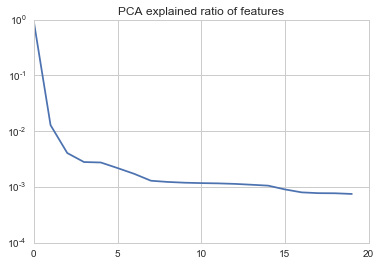

In [50]:
new_PCA=PCA(n_components=20)
new_PCA.fit(features)
plt.plot(new_PCA.explained_variance_ratio_)
plt.yscale('log')
plt.title("PCA explained ratio of features")
print (new_PCA.explained_variance_ratio_)

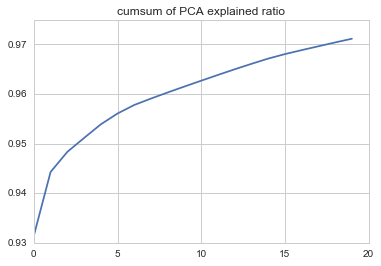

In [51]:
plt.plot(new_PCA.explained_variance_ratio_.cumsum())
plt.title("cumsum of PCA explained ratio")

### 5 Classes of Crimes
- Crime against person : murder , aggravated assaut, rape , robbery etc
 
- Crime against property : theft of property, auto theft , arson , burglary etc
 
- Crime against morality : prostitution, illegal gambling , illegal drug use, also called victimless crimes
 
- White-Collar Crime : committed by high social status persons in the context of their occupation ,eg embezzling,
 
- Organized crime : committed by group of people, eg. illegal distribution of goods, drug trade, weapon smuggling, money laundering etc

In [28]:
features[collist[:-1]].head()

X         Y  Summer  Fall  Winter  Spring  Addr  PD_BAYVIEW  \
0 -0.107902  0.007832       1     0       0       0     1           0   
1 -0.107902  0.007832       1     0       0       0     1           0   
2 -0.057541  0.064335       1     0       0       0     1           0   
3 -0.144262  0.065338       1     0       0       0     0           0   
4 -0.531112  0.001140       1     0       0       0     0           0   

   PD_CENTRAL  PD_INGLESIDE    ...      YEAR_2006  YEAR_2007  YEAR_2008  \
0           0             0    ...              0          0          0   
1           0             0    ...              0          0          0   
2           0             0    ...              0          0          0   
3           0             0    ...              0          0          0   
4           0             0    ...              0          0          0   

   YEAR_2009  YEAR_2010  YEAR_2011  YEAR_2012  YEAR_2013  YEAR_2014  YEAR_2015  
0          0          0          0          0          0          0          1  
1          0          0          0          0          0          0          1  
2          0          0          0          0          0          0          1  
3          0          0          0          0          0          0          1  
4          0          0          0          0          0          0          1  

[5 rows x 104 columns]

### RANDOM FOREST

In [23]:
%%time
training , validation = train_test_split(features,train_size=0.70)
print(len(training) , len(validation))

614634 263415
CPU times: user 2.21 s, sys: 1.93 s, total: 4.13 s
Wall time: 5.57 s


In [43]:
%%time
print ("Training the random forest...")
# Initialize a Random Forest classifier 
forest = RandomForestClassifier(n_estimators=10) 
# This may take a few minutes to run
y_score = forest.fit(training[collist[:-1]],training['crime'])

Training the random forest...
CPU times: user 45.9 s, sys: 3.97 s, total: 49.9 s
Wall time: 51.4 s


In [35]:
predicted = np.array(forest.predict_proba(validation[collist[:-1]]))

#evaluation metric : cross-entropy loss.
log_loss(validation['crime'], predicted) 

13.955800962176195

In [39]:
cv_scores = cross_val_score(forest,training[collist[:-1]],training['crime'])
print(cv_scores)

[ 0.25317364  0.2529957   0.25319477]


In [73]:
from sklearn.metrics import classification_report

In [45]:
# Take the mean accuracy across all cross validation segments.
print('Cross Validation Accuracy: ', cv_scores.mean())

Cross Validation Accuracy:  0.253890976934


In [41]:
predict = forest.predict_proba(training[collist[:-1]])

#Write results
result=pd.DataFrame(predict, columns=category.classes_)
result.to_csv('submit.csv', index = True, index_label = 'Id' )

## BernoulliNB

Naive Bayes classifier for multivariate Bernoulli models.
Like MultinomialNB, this classifier is suitable for discrete data. The difference is that while MultinomialNB works with occurrence counts, BernoulliNB is designed for binary/boolean features.

In [25]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_curve

model = BernoulliNB()
model.fit(training[collist[:-1]], training['crime'])
predicted = np.array(model.predict_proba(validation[collist[:-1]]))

#evaluation metric : cross-entropy loss.
log_loss(validation['crime'], predicted) 

2.5455489822109345

## Applying Test Data Set

In [45]:
def loading_test_set():
    test = pd.read_csv('test.csv')
    return test

In [46]:
loading_test_set().head()

Id                Dates DayOfWeek PdDistrict                   Address  \
0   0  2015-05-10 23:59:00    Sunday    BAYVIEW   2000 Block of THOMAS AV   
1   1  2015-05-10 23:51:00    Sunday    BAYVIEW        3RD ST / REVERE AV   
2   2  2015-05-10 23:50:00    Sunday   NORTHERN    2000 Block of GOUGH ST   
3   3  2015-05-10 23:45:00    Sunday  INGLESIDE  4700 Block of MISSION ST   
4   4  2015-05-10 23:45:00    Sunday  INGLESIDE  4700 Block of MISSION ST   

            X          Y  
0 -122.399588  37.735051  
1 -122.391523  37.732432  
2 -122.426002  37.792212  
3 -122.437394  37.721412  
4 -122.437394  37.721412

In [47]:
# Recode the Response variable 
category = preprocessing.LabelEncoder()
category_crime = category.fit_transform(SNF.Category)
print(category_crime)

[37 21 21 ..., 16 35 12]


In [48]:
#process test set
test_Data = loading_test_set()
test_df = preprocess_data(test_Data)
test_df.head()

Parsing dates...
Creating season features...
Creating Lat/Long feature...
Creating address features...
Creating dummy variables...
Joining features...
Droping processed columns...
Done!


X         Y  Summer  Fall  Winter  Spring  Addr  PD_BAYVIEW  \
0  0.745700 -0.075130       1     0       0       0     0           1   
1  1.005982 -0.080531       1     0       0       0     1           1   
2 -0.106786  0.042772       1     0       0       0     0           0   
3 -0.474449 -0.103262       1     0       0       0     0           0   
4 -0.474449 -0.103262       1     0       0       0     0           0   

   PD_CENTRAL  PD_INGLESIDE    ...      YEAR_2006  YEAR_2007  YEAR_2008  \
0           0             0    ...              0          0          0   
1           0             0    ...              0          0          0   
2           0             0    ...              0          0          0   
3           0             1    ...              0          0          0   
4           0             1    ...              0          0          0   

   YEAR_2009  YEAR_2010  YEAR_2011  YEAR_2012  YEAR_2013  YEAR_2014  YEAR_2015  
0          0          0          0          0          0          0          1  
1          0          0          0          0          0          0          1  
2          0          0          0          0          0          0          1  
3          0          0          0          0          0          0          1  
4          0          0          0          0          0          0          1  

[5 rows x 104 columns]

In [49]:
print('Predicting...')
y_test = pd.DataFrame(forest.predict_proba(test_df), index=test_df.index, columns=forest.classes_)
    
print("Writing results to submit_test.csv...")
# save the result
y_test.to_csv('submit_test.csv', index = True, index_label = 'Id' )

Predicting...
Writing results to submit_test.csv...


## BernoulliNB on Testing Set

In [22]:
print('Predicting...')
y_test = pd.DataFrame(model.predict_proba(test_df), index=test_df.index, columns=model.classes_)
    
print("Writing results to submit-test-NB.csv...")
# save the result
y_test.to_csv('submit_test_NB.csv', index = True, index_label = 'Id' )


Predicting...
Writing results to submit_test.csv...
